In [1]:
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import math

In [2]:
#環境の設定
class Environment():
    def __init__(self):
        #ランダムウォークの設定
        self.states = ['left_goal', 'A', 'B', 'C', 'D', 'E', 'right_goal']
        self.values = [0, 0.5, 0.5, 0.5, 0.5, 0.5, 0]#各状態の初期価値
        self.start = self.states.index('C')#スタート位置
        
     #移動   
    def move(self, state, action):
            if action == 'left':
                return state-1
            else:
                return state+1

In [3]:
#エージェントの設定
class Agent():
    def __init__(self):
        self.actions = ['left', 'right']#右か左に移動
        self.values = []
        self.total_loss = 0
    
    def initialize(self, init_values):#エージェントの初期化関数
        self.values = init_values
        self.total_loss = 0
    
    #移動する方向を選ぶ
    def select_action(self):
        return random.choice(self.actions)

In [4]:
#TD(0)法
class TD_0():
    def __init__(self, num_epi, alpha, gamma):
        self.num_epi = num_epi
        self.alpha = alpha
        self.gamma = gamma
        self.values = [] #推定値
        self.regret = [] #RMS誤差
        
    #価値計算    
    def update_value(self, agent, s, s_next, alpha, r):
        agent.values[s] = agent.values[s] + alpha*(r + self.gamma*agent.values[s_next] - agent.values[s])
            
    #試行する関数
    def run(self, agent, env, num_epi, alpha):
        agent.initialize(copy.deepcopy(env.values))
        regret = []
        
        #エピソード数だけ実行
        for epi in tqdm(range(num_epi)):
            s = env.start
            end = False
            reward = 0
            
            while end==False:
                s_next = env.move(s, agent.select_action())#次の位置を決定
                #次の位置ごとに処理
                if env.states[s_next]=='right_goal':
                    reward = 1
                    end = True
                elif env.states[s_next]=='left_goal':
                    reward = 0
                    end = True
                else:
                    reward = 0
                #価値と位置更新
                self.update_value(agent, s, s_next, alpha, reward)
                s = s_next
                
            #RMS計算    
            regret.append(calc_RMS(agent, epi))
                
        #結果整形
        values = copy.deepcopy(agent.values)
        values.pop(len(env.states)-1)
        values.pop(0)
        return values, regret

In [5]:
#モンテカルロ法
class Montecarlo():
    def __init__(self, num_epi, alpha, gamma):
        self.num_epi = num_epi
        self.alpha = alpha
        self.gamma = gamma
        self.values = []
        self.regret = []
    
    def update_value(self, agent,  state_hist, alpha, r):
        for s in state_hist:
            agent.values[s] = agent.values[s] + alpha*(r - agent.values[s])
        
    def run(self, agent, env, num_epi, alpha):
        agent.initialize(copy.deepcopy(env.values))
        regret = []
        
        for epi in tqdm(range(num_epi)):
            s = env.start
            end = False
            reward = 0
            state_hist = []
        
            while end==False:
                s_next = env.move(s, agent.select_action())
                if env.states[s_next]=='right_goal':
                    reward = 1
                    end = True
                elif env.states[s_next]=='left_goal':
                    reward = 0
                    end = True
                state_hist.append(s)
                s = s_next
            
            regret.append(calc_RMS(agent, epi))
            self.update_value(agent, state_hist, alpha, reward)
        
        values = copy.deepcopy(agent.values)
        values.pop(len(env.states)-1)
        values.pop(0)
        return values, regret

In [6]:
def calc_RMS(agent, count):#RMS誤差計算
    for s in range(1, len(agent.values)-1):
        loss = math.sqrt((agent.values[s] - true_values[s-1])**2)
        agent.total_loss += loss
        
    return agent.total_loss/float(count+1)/5.

def run_each_episodes(method, agent, env):#episodeが複数(list)の場合
    for i in range(len(method.num_epi)):
        _values, _regret = method.run(agent, env, method.num_epi[i], method.alpha)
        method.values.append(_values)
        method.regret.append(_regret)
    
def run_each_alphas(method, agent, env):#alphaが複数(list)の場合
    for i in range(len(method.alpha)):
        _values, _regret = method.run(agent, env, method.num_epi, method.alpha[i])
        method.values.append(_values)
        method.regret.append(_regret)
    
def execution(method, agent, env):#実行する関数
    if type(method.num_epi)==list:
        run_each_episodes(method, agent, env)
    elif type(method.alpha)==list:
        run_each_alphas(method, agent, env)
    else:#episodeもalphaも一つの場合
        method.values, method.regret = method.run(agent, env, method.num_epi, method.alpha)

# 設定

In [7]:
episode = 100
alpha = 0.1
gamma = 1
randomwalk = Environment()
agent = Agent()
initial_values = [0.5, 0.5, 0.5, 0.5, 0.5]#初期価値
true_values = [1/6, 2/6, 3/6, 4/6, 5/6]#真値

# 実行

100%|██████████| 100/100 [00:00<00:00, 22978.71it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

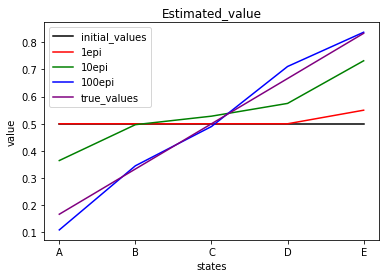

In [8]:
#TD(0)法のエピソード数ごとの各状態に対する推定値のグラフ
#それ用の実行
episodes = [1, 10, 100]
td = TD_0(episodes, alpha, gamma)
execution(td, agent, randomwalk)

#表示
colors = ['black', 'red', 'green', 'blue', 'purple']
labels = ['initial_values', '1epi', '10epi', '100epi', 'true_values']
x = ['A', 'B', 'C', 'D', 'E']
y = [initial_values, td.values[0], td.values[1], td.values[2], true_values]

fig, ax = plt.subplots()
ax.set_xlabel('states')
ax.set_ylabel('value')
ax.set_title('Estimated_value')
for i in range(len(y)):
    ax.plot(x, y[i], color=colors[i], label=labels[i])
ax.legend(loc='best')
plt.show

100%|██████████| 100/100 [00:00<00:00, 19036.46it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

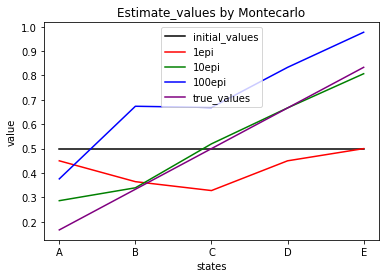

In [9]:
#モンテカルロ法のエピソード数ごとの各状態に対する推定値のグラフ
#それ用の実行
episodes = [1, 10, 100]
mc = Montecarlo(episodes, alpha, gamma)
execution(mc, agent, randomwalk)

#表示
colors = ['black', 'red', 'green', 'blue', 'purple']
labels = ['initial_values', '1epi', '10epi', '100epi', 'true_values']
x = ['A', 'B', 'C', 'D', 'E']
y = [initial_values, mc.values[0], mc.values[1], mc.values[2], true_values]

fig, ax = plt.subplots()
ax.set_xlabel('states')
ax.set_ylabel('value')
ax.set_title('Estimate_values by Montecarlo')
for i in range(len(y)):
    ax.plot(x, y[i], color=colors[i], label=labels[i])
ax.legend(loc='best')
plt.show

100%|██████████| 100/100 [00:00<00:00, 27832.14it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

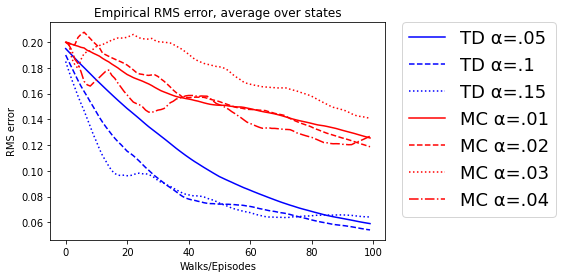

In [10]:
#各手法の様々なαごとのエピソード数に対するRMS誤差のグラフ
#TD(0)法の実行
td_alphas = [0.05, 0.1, 0.15]
td = TD_0(episode, td_alphas, gamma)
execution(td, agent, randomwalk)

#モンテカルロ法の実行
mc_alphas = [0.01, 0.02, 0.03, 0.04]
mc = Montecarlo(episode, mc_alphas, gamma)
execution(mc, agent, randomwalk)

#表示
td_labels = ['TD α=.05', 'TD α=.1', 'TD α=.15']
td_lines = ['solid', 'dashed', 'dotted']
mc_labels = ['MC α=.01', 'MC α=.02', 'MC α=.03', 'MC α=.04']
mc_lines = ['solid', 'dashed', 'dotted', 'dashdot']
fig, ax = plt.subplots()
ax.set_xlabel('Walks/Episodes')
ax.set_ylabel('RMS error')
ax.set_title('Empirical RMS error, average over states')
for i in range(len(td.regret)):
    ax.plot(range(100), td.regret[i], color='blue', linestyle=td_lines[i], label=td_labels[i])
for i in range(len(mc.regret)):
    ax.plot(range(100), mc.regret[i], color='red', linestyle=mc_lines[i], label=mc_labels[i])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show